In [27]:
import json, os, pandas as pd

def load_metrics_json(path):
    with open(path) as f:
        return json.load(f)

paths = {
    #"logreg_ridge": "./experiments/linear_baselines_v1/metrics.json",
    "logistic_reg": "./experiments/logistic_reg_v1/metrics.json",
    "ridge_reg": "./experiments/ridge_reg_v1/metrics.json",
    "random_forest": "./experiments/random_forest_v1/metrics.json",
    "neural_network": "./experiments/ann_v1/metrics.json",
    "xgboost": "./experiments/xgboost_v1/metrics.json",
    "lightGBM": "./experiments/lightgbm_v1/metrics.json",
    "catboost": "./experiments/catboost_v1/metrics.json",
    #"stackingOOF": "./experiments/stacking_v1/metrics.json",
    #"stackingPlus": "./experiments/stacking_plus_v1/metrics.json"
}

rows = []
for name, mpath in paths.items():
    m = load_metrics_json(mpath)
    # Baselines: 'logreg', 'ridge', 'calibrated' ; RF: 'rf', 'rf_calibrated'
    for key, val in m.items():
        if not isinstance(val, dict): 
            continue

        modelo = val.get("model") if "model" in val else key
        rows.append({
            "exp": name, "model": modelo,
            "roc_auc": val.get("roc_auc"), "pr_auc": val.get("pr_auc"),
            "f1": val.get("f1"), "accuracy": val.get("accuracy"),
            "brier": val.get("brier")
        })

df_cmp = pd.DataFrame(rows).sort_values(["pr_auc","roc_auc"], ascending=False)
df_cmp


,exp,model,roc_auc,pr_auc,f1,accuracy,brier
9,lightGBM,lightgbm,0.884664,0.872983,0.763772,0.810912,0.141139
10,lightGBM,lightgbm_calibrated_isotonic,0.886156,0.872523,0.750716,0.804933,0.134683
11,catboost,catboost,0.884244,0.871188,0.766791,0.813154,0.134613
7,xgboost,xgboost,0.885255,0.870647,0.757974,0.807175,0.134708
8,xgboost,xgboost_calibrated_isotonic,0.883980,0.868122,0.766478,0.814649,0.134626
12,catboost,catboost_calibrated_isotonic,0.884148,0.867899,0.773460,0.821375,0.133374
3,random_forest,random_forest,0.878891,0.864661,0.757717,0.806428,0.142542
4,random_forest,rf_calibrated_isotonic,0.873618,0.858497,0.755179,0.805680,0.139492
6,neural_network,ann_calibrated_isotonic,0.815084,0.767651,0.691882,0.750374,0.173729
5,neural_network,ann_mlp,0.803051,0.753547,0.691638,0.735426,0.183765


In [28]:
# aca voy a dejar de lado los isotonics, no dieron mejores resultados.. 

rows = []
for name, mpath in paths.items():
    m = load_metrics_json(mpath)
    # Baselines: 'logreg', 'ridge', 'calibrated' ; RF: 'rf', 'rf_calibrated'
    for key, val in m.items():
        if not isinstance(val, dict): 
            continue

        modelo = val.get("model") if "model" in val else key
        if 'isotonic' not in modelo:
            rows.append({
                "exp": name, "model": modelo,
                "roc_auc": val.get("roc_auc"), "pr_auc": val.get("pr_auc"),
                "f1": val.get("f1"), "accuracy": val.get("accuracy"),
                "brier": val.get("brier")
            })

df_cmp = pd.DataFrame(rows).sort_values(["pr_auc","roc_auc"], ascending=False)
df_cmp


,exp,model,roc_auc,pr_auc,f1,accuracy,brier
5,lightGBM,lightgbm,0.884664,0.872983,0.763772,0.810912,0.141139
6,catboost,catboost,0.884244,0.871188,0.766791,0.813154,0.134613
4,xgboost,xgboost,0.885255,0.870647,0.757974,0.807175,0.134708
2,random_forest,random_forest,0.878891,0.864661,0.757717,0.806428,0.142542
3,neural_network,ann_mlp,0.803051,0.753547,0.691638,0.735426,0.183765
1,ridge_reg,ridge,0.785646,0.726925,0.702658,0.732436,0.206058
0,logistic_reg,logreg,0.784060,0.724983,0.702568,0.731689,0.188271


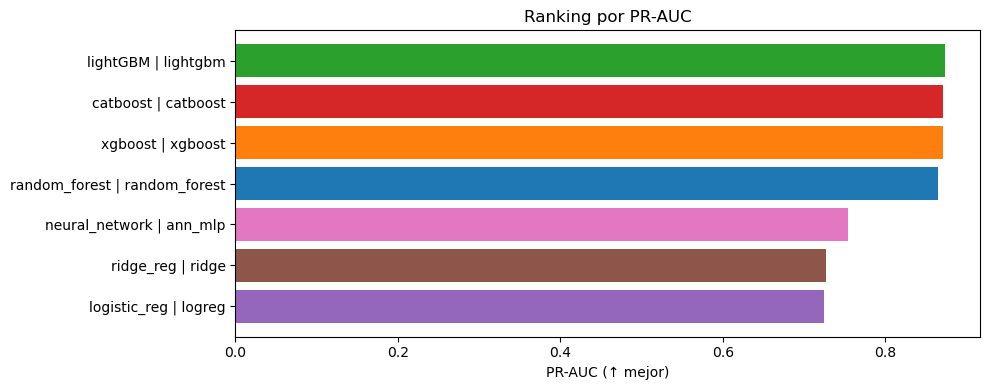

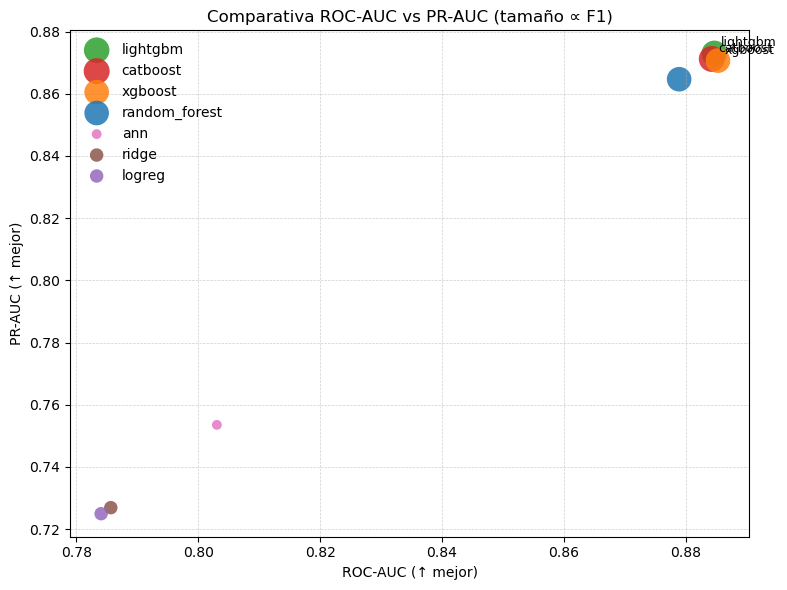

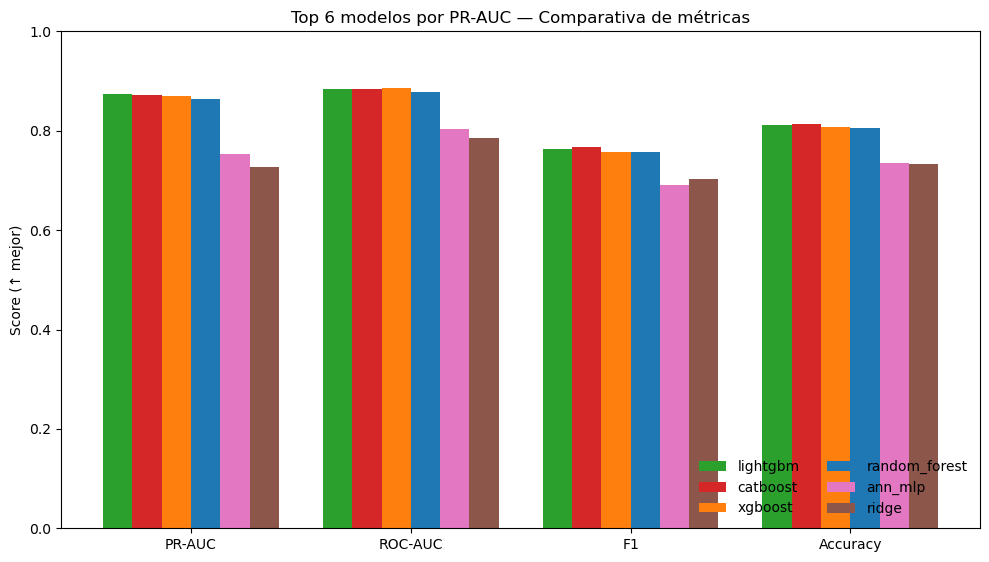

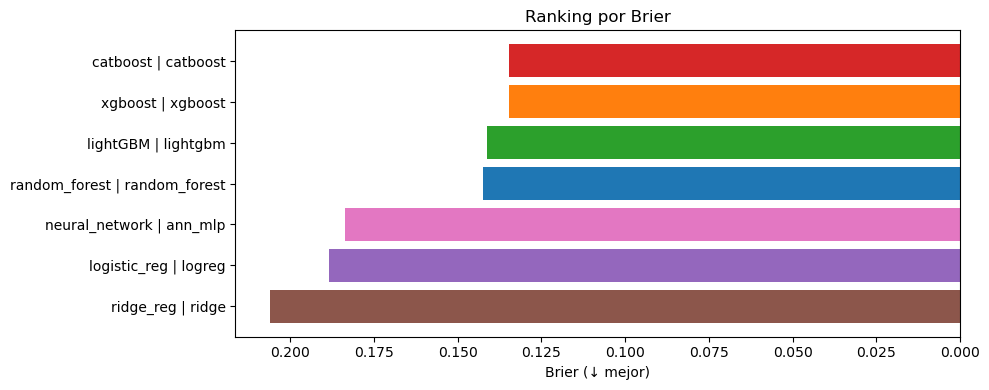

Figuras guardadas en: graficos/comparativa/figs_cmp_v1
 - ranking_pr_auc.png
 - scatter_roc_vs_pr.png
 - grouped_bars_topN_metrics.png
 - ranking_brier.png


In [29]:
# ===========================================
# Figuras comparativas para df_cmp (matplotlib)
# Requiere df_cmp ya definido como en tu snippet.
# ===========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Comprobación
if "df_cmp" not in globals():
    raise RuntimeError("df_cmp no está definido. Asegurate de ejecutar primero la celda que construye df_cmp.")

STAMP = time.strftime("%Y%m%d_%H%M%S")
FIG_DIR = f"graficos/comparativa/figs_cmp_v1"
os.makedirs(FIG_DIR, exist_ok=True)

# --- Normalización de etiquetas y extracción de familia de modelo
dfv = df_cmp.copy()

def model_family(m):
    m = str(m).lower()
    if "xgb" in m or "xboost" in m:
        return "xgboost"
    if "lgb" in m or "lightgbm" in m:
        return "lightgbm"
    if "cat" in m:
        return "catboost"
    if "ridge" in m:
        return "ridge"
    if "logreg" in m or "logistic" in m:
        return "logreg"
    if "rf" in m or "forest" in m:
        return "random_forest"
    if "ann_keras" in m:
        return "ann_keras"
    if "ann" in m:
        return "ann"
    return "otros"

dfv["family"] = dfv["model"].apply(model_family)
dfv["label"]  = dfv["exp"].astype(str) + " | " + dfv["model"].astype(str)

# --- Colores por familia (puede ajustar si agregás familias nuevas)
FAMILY_COLORS = {
    "random_forest": "#1f77b4",
    "xgboost": "#ff7f0e",
    "lightgbm": "#2ca02c",
    "catboost": "#d62728",
    "logreg": "#9467bd",
    "ridge": "#8c564b",
    "ann": "#e377c2",
    "ann_keras": "#17becf",
    "otros": "#7f7f7f",
}
dfv["color"] = dfv["family"].map(FAMILY_COLORS).fillna("#7f7f7f")

# =========================
# 1) Ranking PR-AUC (barra)
# =========================
df_pr = dfv.sort_values("pr_auc", ascending=True)  # para que la barra más alta quede arriba al hacer horizontal
labels = df_pr["label"].tolist()
vals   = df_pr["pr_auc"].values
cols   = df_pr["color"].tolist()

plt.figure(figsize=(10, max(4, 0.35*len(df_pr))))
plt.barh(labels, vals, color=cols)
plt.xlabel("PR-AUC (↑ mejor)")
plt.title("Ranking por PR-AUC")
plt.tight_layout()
path1 = os.path.join(FIG_DIR, "ranking_pr_auc.png")
plt.savefig(path1, dpi=200, bbox_inches="tight"); plt.show(); plt.close()

# ===================================
# 2) Scatter ROC-AUC vs PR-AUC (F1=∅)
# ===================================
# tamaño de punto escalado por F1 (evita NaN)
f1 = dfv["f1"].fillna(0.0).values
size = 300 * (f1 - np.nanmin(f1) + 1e-6) / (np.nanmax(f1) - np.nanmin(f1) + 1e-6) + 50

plt.figure(figsize=(8,6))
for fam in dfv["family"].unique():
    sub = dfv[dfv["family"] == fam]
    plt.scatter(sub["roc_auc"], sub["pr_auc"], s=size[dfv["family"] == fam], 
                label=fam, color=FAMILY_COLORS.get(fam, "#7f7f7f"), alpha=0.85, edgecolors="none")
# anota top-3 por PR-AUC
top3 = dfv.sort_values("pr_auc", ascending=False).head(3)
for _, r in top3.iterrows():
    plt.annotate(r["model"], (r["roc_auc"], r["pr_auc"]), xytext=(5,5), textcoords="offset points", fontsize=9)
plt.xlabel("ROC-AUC (↑ mejor)")
plt.ylabel("PR-AUC (↑ mejor)")
plt.title("Comparativa ROC-AUC vs PR-AUC (tamaño ∝ F1)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(frameon=False)
plt.tight_layout()
path2 = os.path.join(FIG_DIR, "scatter_roc_vs_pr.png")
plt.savefig(path2, dpi=200, bbox_inches="tight"); plt.show(); plt.close()

# ====================================================
# 3) Barras agrupadas por métrica (Top-N por PR-AUC)
# ====================================================
TOP_N = min(6, len(dfv))
df_top = dfv.sort_values("pr_auc", ascending=False).head(TOP_N).reset_index(drop=True)

metrics = ["pr_auc", "roc_auc", "f1", "accuracy"]
metric_titles = {"pr_auc":"PR-AUC", "roc_auc":"ROC-AUC", "f1":"F1", "accuracy":"Accuracy"}

x = np.arange(len(metrics))
w = 0.8 / TOP_N  # ancho por barra

plt.figure(figsize=(10, 5 + 0.12*TOP_N))
for i, (_, row) in enumerate(df_top.iterrows()):
    vals = [row[m] for m in metrics]
    plt.bar(x + i*w - 0.4 + w/2, vals, width=w, label=row["model"], color=row["color"])
plt.xticks(x, [metric_titles[m] for m in metrics])
plt.ylim(0, 1.0)
plt.ylabel("Score (↑ mejor)")
plt.title(f"Top {TOP_N} modelos por PR-AUC — Comparativa de métricas")
plt.legend(loc="lower right", ncol=2, frameon=False)
plt.tight_layout()
path3 = os.path.join(FIG_DIR, "grouped_bars_topN_metrics.png")
plt.savefig(path3, dpi=200, bbox_inches="tight"); plt.show(); plt.close()

# ===================================
# 4) Ranking Brier (menor es mejor)
# ===================================
if "brier" in dfv.columns and not dfv["brier"].isna().all():
    df_b = dfv.sort_values("brier", ascending=False)  # para que el mejor quede arriba al hacer horizontal con x invertida
    labels_b = df_b["label"].tolist()
    vals_b   = df_b["brier"].values
    cols_b   = df_b["color"].tolist()

    plt.figure(figsize=(10, max(4, 0.35*len(df_b))))
    plt.barh(labels_b, vals_b, color=cols_b)
    plt.xlabel("Brier (↓ mejor)")
    plt.title("Ranking por Brier")
    # invertir eje X para que el mejor (menor) quede más a la derecha
    ax = plt.gca()
    ax.invert_xaxis()
    plt.tight_layout()
    path4 = os.path.join(FIG_DIR, "ranking_brier.png")
    plt.savefig(path4, dpi=200, bbox_inches="tight"); plt.show(); plt.close()

print("Figuras guardadas en:", FIG_DIR)
print(" -", os.path.basename(path1))
print(" -", os.path.basename(path2))
print(" -", os.path.basename(path3))
if "brier" in dfv.columns and not dfv["brier"].isna().all():
    print(" -", os.path.basename(path4))


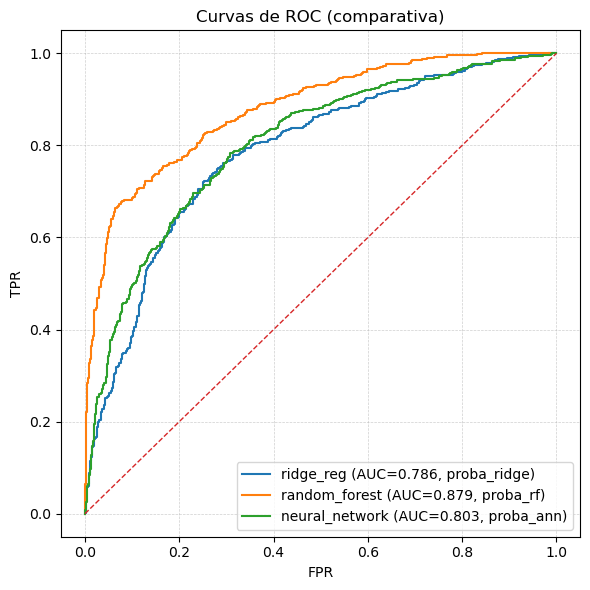

Figura ROC guardada en: experiments/figs_cmp_v2\roc_curves.png


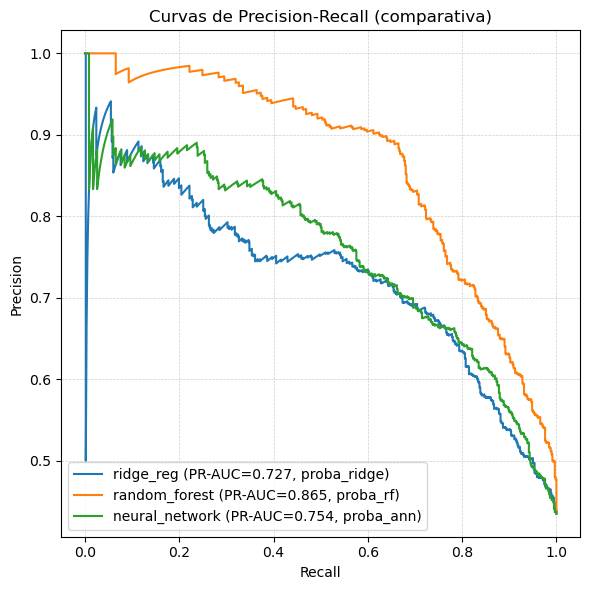

Figura PR-AUC guardada en: experiments/figs_cmp_v2\pr_curves.png


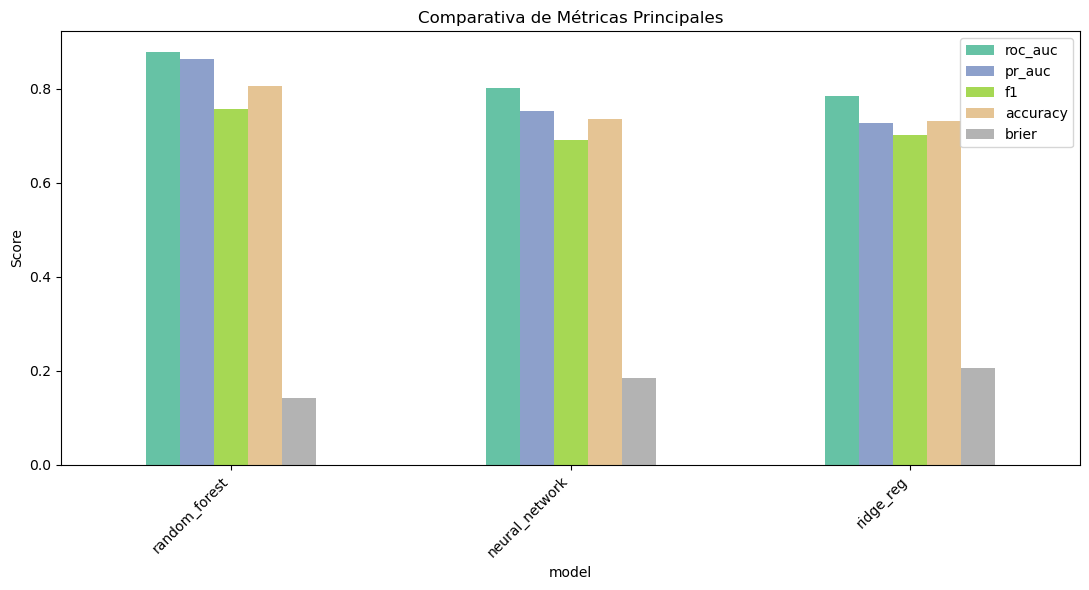

Figura de barras guardada en: experiments/figs_cmp_v2\bar_metrics_comparison.png


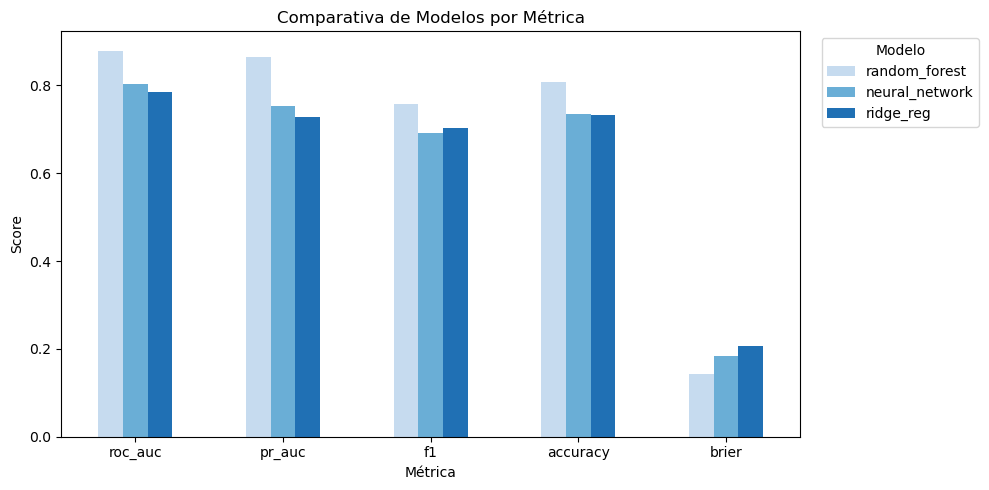

Figura transpuesta guardada en: experiments/figs_cmp_v2\bar_metrics_comparison_transposed.png


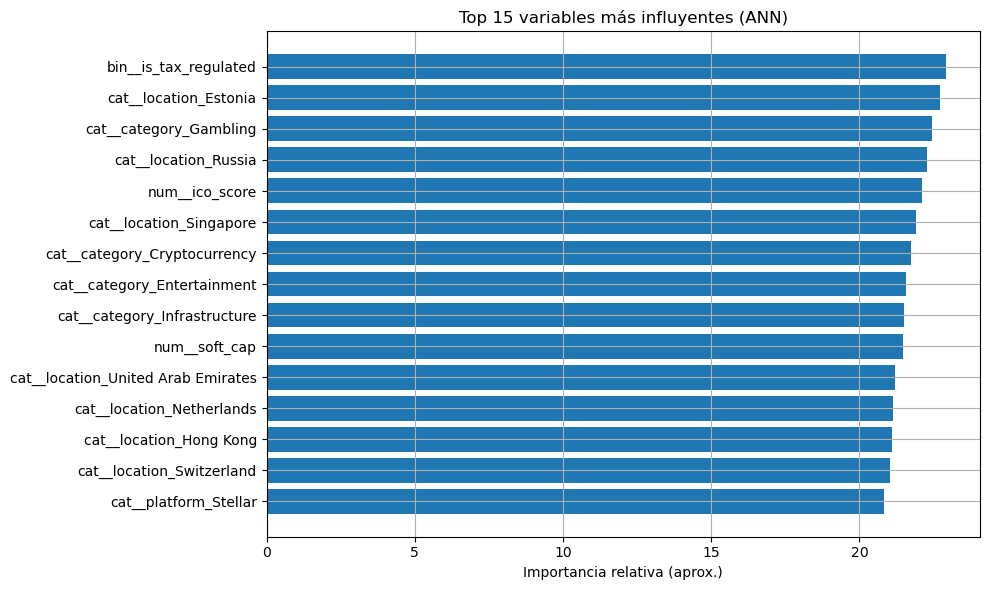

Figura guardada en: experiments/figs_cmp_v2\top_features_ann.png


In [20]:
# ===========================================
# ROC comparativa (cargando test_predictions.csv)
# ===========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


# EDITÁ: etiquetas -> carpeta del experimento (donde está test_predictions.csv)
exp_paths = {
    #"logreg_ridge": "./experiments/linear_baselines_v1",
    #"logistic_reg": "./experiments/logistic_reg_v1",
    "ridge_reg": "./experiments/ridge_reg_v1",
    "random_forest": "./experiments/random_forest_v1",
    "neural_network": "./experiments/ann_v1",
    #"xgboost": "./experiments/xgboost_v1",
    #"lightGBM": "./experiments/lightGBM_v1",
    #"catboost": "./experiments/catboost_v1",
    #"stackingOOF": "./experiments/stacking_v1",
    #"stackingPlus": "./experiments/stacking_plus_v1"
}

# Si querés filtrar calibrados o no, podés armar dos listas y graficar por separado.

def load_pred(csv_path):
    dfp = pd.read_csv(csv_path)
    # Heurística para encontrar columna de probas
    proba_cols = [c for c in dfp.columns if c.lower() in ("y_proba","proba_cal","proba_rf","proba_rf_cal","proba_raw")]
    if not proba_cols:
        # fallback: primera col que empiece con 'proba'
        proba_cols = [c for c in dfp.columns if c.lower().startswith("proba")]
    if "y_true" not in dfp.columns or not proba_cols:
        raise ValueError(f"Columnas esperadas no encontradas en {csv_path} (necesito y_true y alguna proba_*)")
    # preferí calibrada si existe
    preferred = None
    for cand in ["proba_cal","y_proba"]:
        if cand in dfp.columns:
            preferred = cand
            break
    if preferred is None:
        preferred = proba_cols[0]
    y_true = dfp["y_true"].astype(int).values
    y_proba = dfp[preferred].astype(float).values
    return y_true, y_proba, preferred

STAMP = time.strftime("%Y%m%d_%H%M%S")
FIG_DIR = f"experiments/figs_cmp_v2"
os.makedirs(FIG_DIR, exist_ok=True)

# plt.figure(figsize=(8.5, 6))
# handles = []
# labels  = []

# for label, exp_dir in exp_paths.items():
#     csv_path = os.path.join(exp_dir, "test_predictions.csv")
#     if not os.path.exists(csv_path):
#         print(f"[WARN] No existe: {csv_path} — lo salto.")
#         continue
#     y_true, y_proba, which = load_pred(csv_path)
#     fpr, tpr, _ = roc_curve(y_true, y_proba)
#     auc = roc_auc_score(y_true, y_proba)
#     h, = plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")
#     handles.append(h); labels.append(label)


# ---------------------------
# ROC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] No existe: {csv_path} — lo salto.")
        continue
    y_true, y_proba, which = load_pred(csv_path)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas de ROC (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
roc_path = os.path.join(FIG_DIR, "roc_curves.png")
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura ROC guardada en:", roc_path)


# ---------------------------
# PR-AUC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        continue
    y_true, y_proba, which = load_pred(csv_path)
    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, prec, label=f"{label} (PR-AUC={ap:.3f}, {which})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas de Precision-Recall (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
pr_path = os.path.join(FIG_DIR, "pr_curves.png")
plt.savefig(pr_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura PR-AUC guardada en:", pr_path)


# ----------------------------------------
# Barras comparando métricas principales
# ----------------------------------------
import json
metrics = []
for label, exp_dir in exp_paths.items():
    metrics_path = os.path.join(exp_dir, "metrics.json")
    if not os.path.exists(metrics_path): continue
    with open(metrics_path) as f:
        mets = json.load(f)
        # detecta clave de modelo
        key = list(mets.keys())[0]
        val = mets[key]
        metrics.append({
            "model": label,
            "roc_auc": val["roc_auc"],
            "pr_auc": val["pr_auc"],
            "f1": val["f1"],
            "accuracy": val["accuracy"],
            "brier": val["brier"]
        })
dfm = pd.DataFrame(metrics).set_index("model").sort_values("pr_auc", ascending=False)

ax = dfm.plot(kind="bar", figsize=(11, 6), colormap="Set2")
plt.title("Comparativa de Métricas Principales")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
bar_path = os.path.join(FIG_DIR, "bar_metrics_comparison.png")
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura de barras guardada en:", bar_path)

# ----------------------------------------
# Barras transpuestas: métricas en eje X, modelos en colores verdes
# ----------------------------------------
import seaborn as sns

# Transponemos para que métricas sean columnas
dfm_t = dfm.transpose()

# Paleta verde personalizada (usamos tonos diferentes si hay muchos modelos)
green_palette = sns.color_palette("Blues", n_colors=len(dfm_t.columns))

ax = dfm_t.plot(kind="bar", figsize=(10, 5), color=green_palette)
plt.title("Comparativa de Modelos por Métrica")
plt.ylabel("Score")
plt.xlabel("Métrica")
plt.xticks(rotation=0)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
bar_transposed_path = os.path.join(FIG_DIR, "bar_metrics_comparison_transposed.png")
plt.savefig(bar_transposed_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura transpuesta guardada en:", bar_transposed_path)

# ----------------------------------------
# Top 15 más importantes
# ----------------------------------------
# Cargar el modelo entrenado
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargá el modelo con el preprocesamiento y ANN
model = joblib.load("experiments/ann_v1/best_rf.pkl")  # corregí el nombre si es otro

# Extraer nombres de variables del preprocesador
feature_names = model.named_steps["pre"].get_feature_names_out()

# Extraer coeficientes de la primera capa oculta (aprox. de importancia)
# .coefs_ es una lista de arrays: una por cada capa, entre capas. Tomamos la primera.
coefs_input_hidden = model.named_steps["clf"].coefs_[0]  # shape: (n_features, n_hidden)

# Calculamos la importancia como la suma del valor absoluto por neurona de entrada
importances = np.abs(coefs_input_hidden).sum(axis=1)

# Tomamos las 15 más importantes
indices = np.argsort(importances)[-15:][::-1]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[indices], align='center')
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa (aprox.)")
plt.title("Top 15 variables más influyentes (ANN)")
plt.grid(True)
plt.tight_layout()

top_features_path = os.path.join(FIG_DIR, "top_features_ann.png")
plt.savefig(top_features_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura guardada en:", top_features_path)



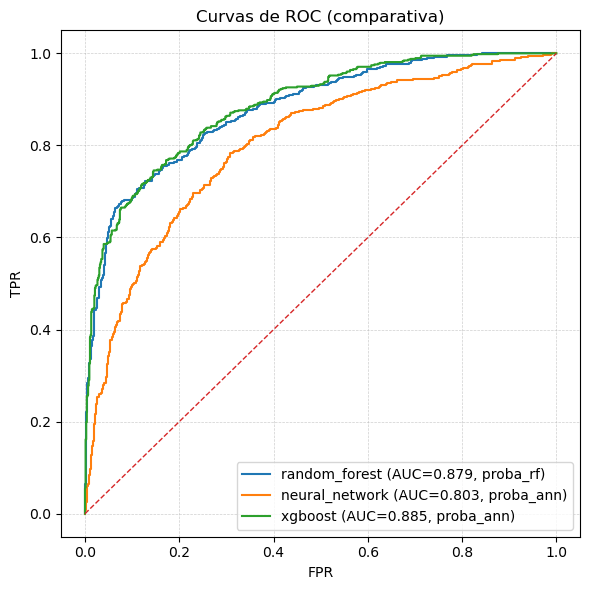

Figura ROC guardada en: experiments/figs_cmp_xgboost_v3\roc_curves.png


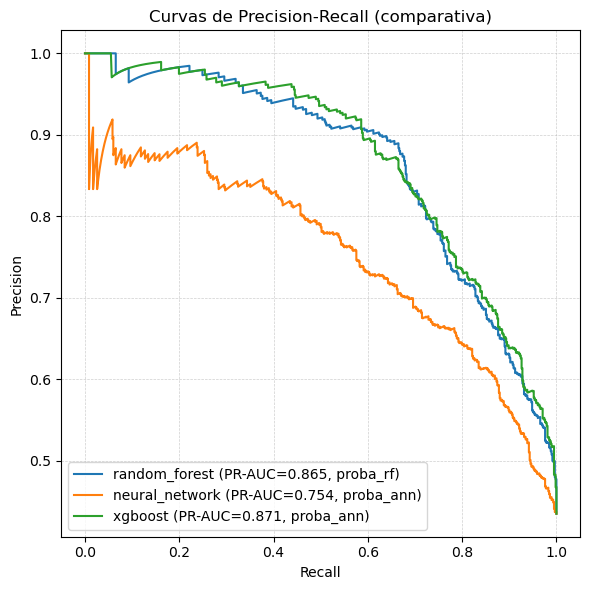

Figura PR-AUC guardada en: experiments/figs_cmp_xgboost_v3\pr_curves.png


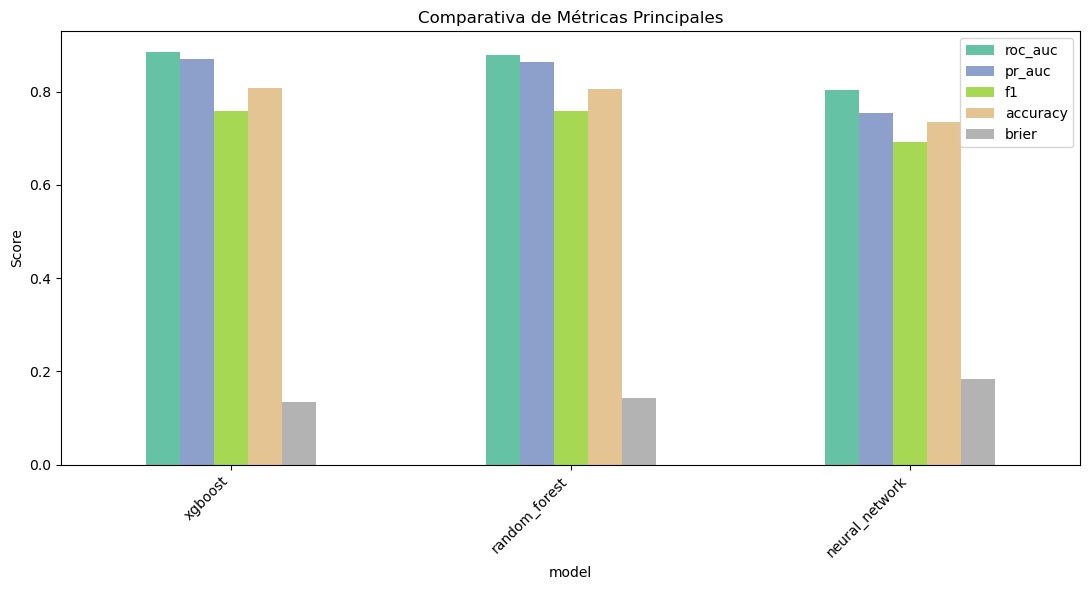

Figura de barras guardada en: experiments/figs_cmp_xgboost_v3\bar_metrics_comparison.png


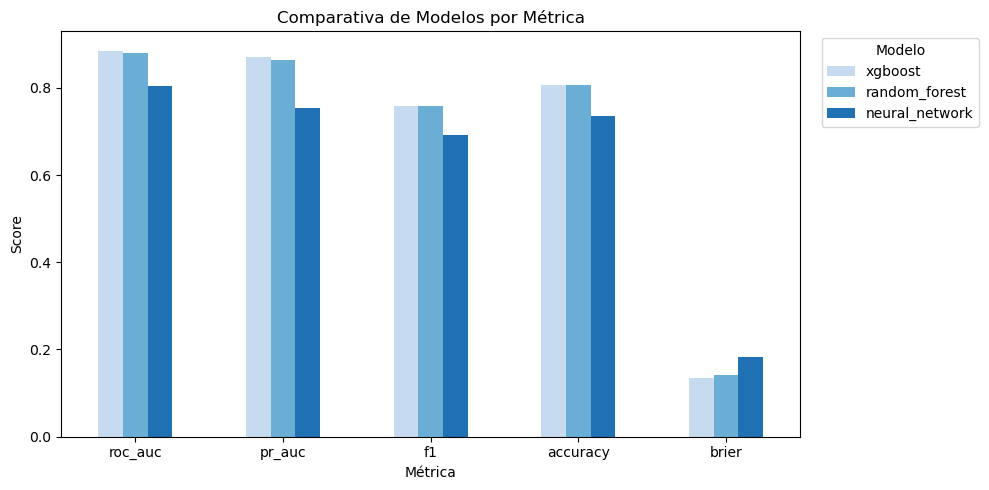

Figura transpuesta guardada en: experiments/figs_cmp_xgboost_v3\bar_metrics_comparison_transposed.png


AttributeError: 'XGBClassifier' object has no attribute 'coefs_'

In [21]:
# ===========================================
# ROC comparativa (cargando test_predictions.csv)
# ===========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


# EDITÁ: etiquetas -> carpeta del experimento (donde está test_predictions.csv)
exp_paths = {
    #"logreg_ridge": "./experiments/linear_baselines_v1",
    #"logistic_reg": "./experiments/logistic_reg_v1",
    #"ridge_reg": "./experiments/ridge_reg_v1",
    "random_forest": "./experiments/random_forest_v1",
    "neural_network": "./experiments/ann_v1",
    "xgboost": "./experiments/xgboost_v1",
    #"lightGBM": "./experiments/lightGBM_v1",
    #"catboost": "./experiments/catboost_v1",
    #"stackingOOF": "./experiments/stacking_v1",
    #"stackingPlus": "./experiments/stacking_plus_v1"
}

# Si querés filtrar calibrados o no, podés armar dos listas y graficar por separado.

def load_pred(csv_path):
    dfp = pd.read_csv(csv_path)
    # Heurística para encontrar columna de probas
    proba_cols = [c for c in dfp.columns if c.lower() in ("y_proba","proba_cal","proba_rf","proba_rf_cal","proba_raw")]
    if not proba_cols:
        # fallback: primera col que empiece con 'proba'
        proba_cols = [c for c in dfp.columns if c.lower().startswith("proba")]
    if "y_true" not in dfp.columns or not proba_cols:
        raise ValueError(f"Columnas esperadas no encontradas en {csv_path} (necesito y_true y alguna proba_*)")
    # preferí calibrada si existe
    preferred = None
    for cand in ["proba_cal","y_proba"]:
        if cand in dfp.columns:
            preferred = cand
            break
    if preferred is None:
        preferred = proba_cols[0]
    y_true = dfp["y_true"].astype(int).values
    y_proba = dfp[preferred].astype(float).values
    return y_true, y_proba, preferred

STAMP = time.strftime("%Y%m%d_%H%M%S")
FIG_DIR = f"experiments/figs_cmp_xgboost_v3"
os.makedirs(FIG_DIR, exist_ok=True)

# plt.figure(figsize=(8.5, 6))
# handles = []
# labels  = []

# for label, exp_dir in exp_paths.items():
#     csv_path = os.path.join(exp_dir, "test_predictions.csv")
#     if not os.path.exists(csv_path):
#         print(f"[WARN] No existe: {csv_path} — lo salto.")
#         continue
#     y_true, y_proba, which = load_pred(csv_path)
#     fpr, tpr, _ = roc_curve(y_true, y_proba)
#     auc = roc_auc_score(y_true, y_proba)
#     h, = plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")
#     handles.append(h); labels.append(label)


# ---------------------------
# ROC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] No existe: {csv_path} — lo salto.")
        continue
    y_true, y_proba, which = load_pred(csv_path)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas de ROC (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
roc_path = os.path.join(FIG_DIR, "roc_curves.png")
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura ROC guardada en:", roc_path)


# ---------------------------
# PR-AUC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        continue
    y_true, y_proba, which = load_pred(csv_path)
    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, prec, label=f"{label} (PR-AUC={ap:.3f}, {which})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas de Precision-Recall (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
pr_path = os.path.join(FIG_DIR, "pr_curves.png")
plt.savefig(pr_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura PR-AUC guardada en:", pr_path)


# ----------------------------------------
# Barras comparando métricas principales
# ----------------------------------------
import json
metrics = []
for label, exp_dir in exp_paths.items():
    metrics_path = os.path.join(exp_dir, "metrics.json")
    if not os.path.exists(metrics_path): continue
    with open(metrics_path) as f:
        mets = json.load(f)
        # detecta clave de modelo
        key = list(mets.keys())[0]
        val = mets[key]
        metrics.append({
            "model": label,
            "roc_auc": val["roc_auc"],
            "pr_auc": val["pr_auc"],
            "f1": val["f1"],
            "accuracy": val["accuracy"],
            "brier": val["brier"]
        })
dfm = pd.DataFrame(metrics).set_index("model").sort_values("pr_auc", ascending=False)

ax = dfm.plot(kind="bar", figsize=(11, 6), colormap="Set2")
plt.title("Comparativa de Métricas Principales")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
bar_path = os.path.join(FIG_DIR, "bar_metrics_comparison.png")
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura de barras guardada en:", bar_path)

# ----------------------------------------
# Barras transpuestas: métricas en eje X, modelos en colores verdes
# ----------------------------------------
import seaborn as sns

# Transponemos para que métricas sean columnas
dfm_t = dfm.transpose()

# Paleta verde personalizada (usamos tonos diferentes si hay muchos modelos)
green_palette = sns.color_palette("Blues", n_colors=len(dfm_t.columns))

ax = dfm_t.plot(kind="bar", figsize=(10, 5), color=green_palette)
plt.title("Comparativa de Modelos por Métrica")
plt.ylabel("Score")
plt.xlabel("Métrica")
plt.xticks(rotation=0)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
bar_transposed_path = os.path.join(FIG_DIR, "bar_metrics_comparison_transposed.png")
plt.savefig(bar_transposed_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura transpuesta guardada en:", bar_transposed_path)

# ----------------------------------------
# Top 15 más importantes
# ----------------------------------------
# Cargar el modelo entrenado
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargá el modelo con el preprocesamiento y ANN
model = joblib.load("experiments/xgboost_v1/best_xgb.pkl")  # corregí el nombre si es otro

# Extraer nombres de variables del preprocesador
feature_names = model.named_steps["pre"].get_feature_names_out()

# Extraer coeficientes de la primera capa oculta (aprox. de importancia)
# .coefs_ es una lista de arrays: una por cada capa, entre capas. Tomamos la primera.
coefs_input_hidden = model.named_steps["clf"].coefs_[0]  # shape: (n_features, n_hidden)

# Calculamos la importancia como la suma del valor absoluto por neurona de entrada
importances = np.abs(coefs_input_hidden).sum(axis=1)

# Tomamos las 15 más importantes
indices = np.argsort(importances)[-15:][::-1]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[indices], align='center')
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa (aprox.)")
plt.title("Top 15 variables más influyentes (XGBoost)")
plt.grid(True)
plt.tight_layout()

top_features_path = os.path.join(FIG_DIR, "top_features_ann.png")
plt.savefig(top_features_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura guardada en:", top_features_path)



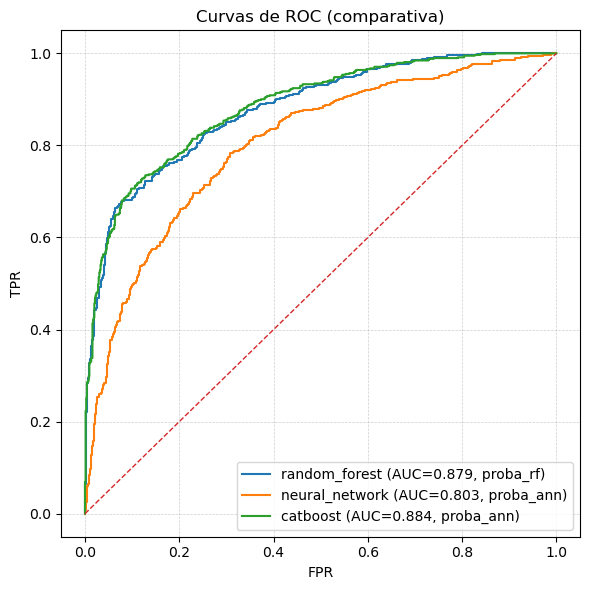

Figura ROC guardada en: experiments/figs_cmp_catboost_v4\roc_curves.png


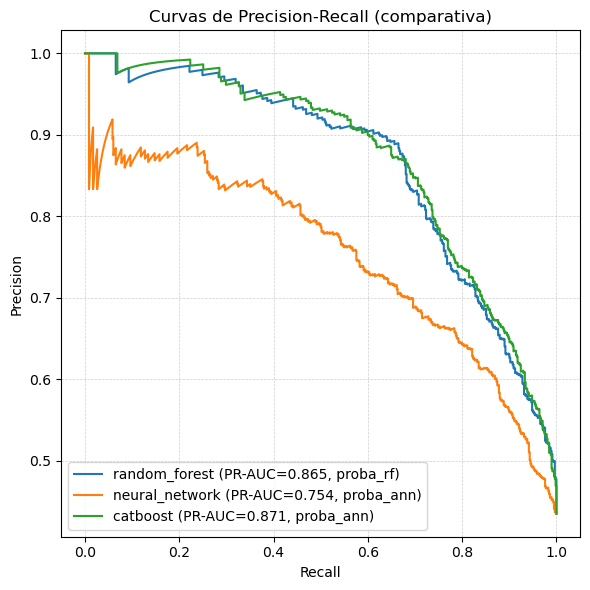

Figura PR-AUC guardada en: experiments/figs_cmp_catboost_v4\pr_curves.png


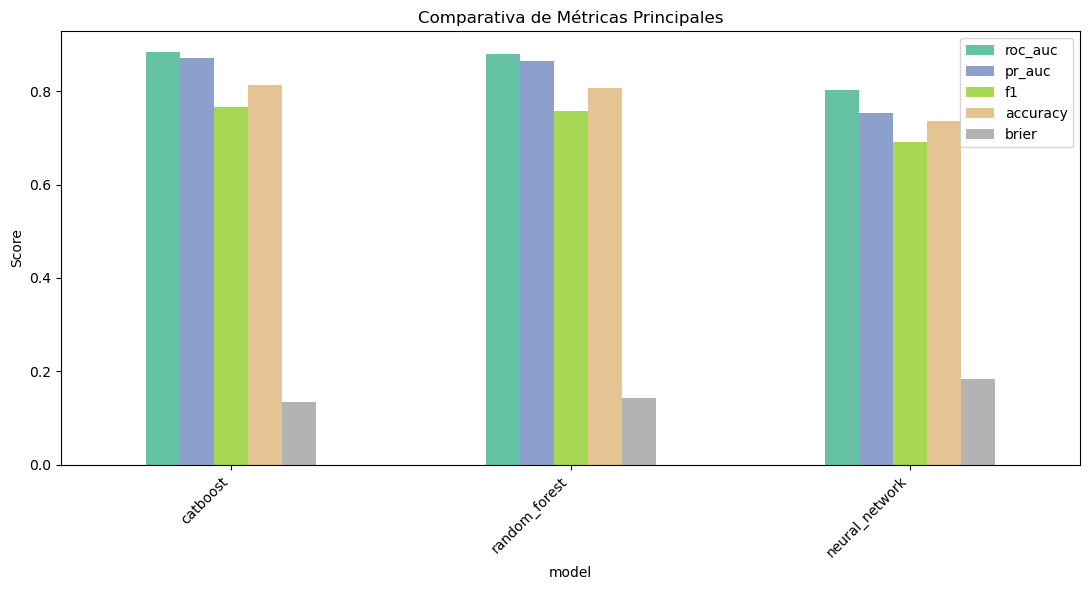

Figura de barras guardada en: experiments/figs_cmp_catboost_v4\bar_metrics_comparison.png


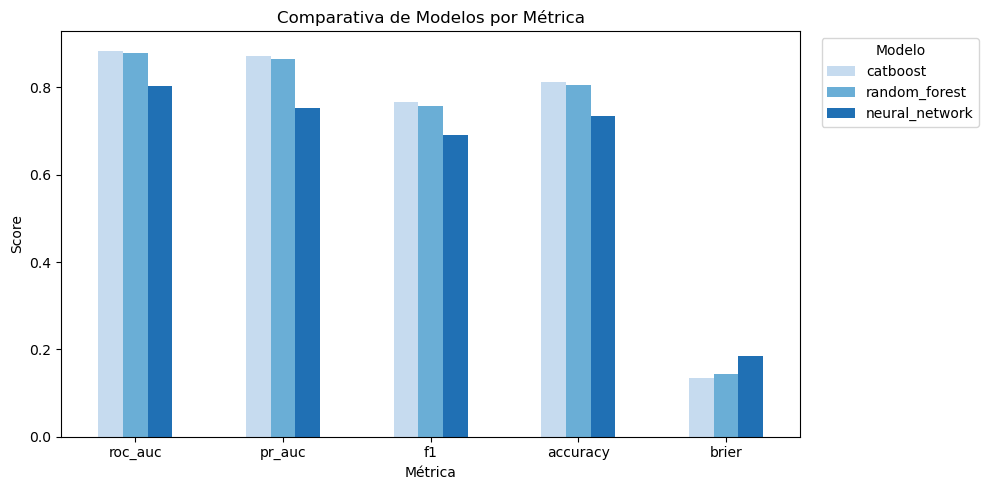

Figura transpuesta guardada en: experiments/figs_cmp_catboost_v4\bar_metrics_comparison_transposed.png


AttributeError: 'CatBoostClassifier' object has no attribute 'coefs_'

In [22]:
# ===========================================
# ROC comparativa (cargando test_predictions.csv)
# ===========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


# EDITÁ: etiquetas -> carpeta del experimento (donde está test_predictions.csv)
exp_paths = {
    #"logreg_ridge": "./experiments/linear_baselines_v1",
    #"logistic_reg": "./experiments/logistic_reg_v1",
    #"ridge_reg": "./experiments/ridge_reg_v1",
    "random_forest": "./experiments/random_forest_v1",
    "neural_network": "./experiments/ann_v1",
    #"xgboost": "./experiments/xgboost_v1",
    #"lightGBM": "./experiments/lightGBM_v1",
    "catboost": "./experiments/catboost_v1",
    #"stackingOOF": "./experiments/stacking_v1",
    #"stackingPlus": "./experiments/stacking_plus_v1"
}

# Si querés filtrar calibrados o no, podés armar dos listas y graficar por separado.

def load_pred(csv_path):
    dfp = pd.read_csv(csv_path)
    # Heurística para encontrar columna de probas
    proba_cols = [c for c in dfp.columns if c.lower() in ("y_proba","proba_cal","proba_rf","proba_rf_cal","proba_raw")]
    if not proba_cols:
        # fallback: primera col que empiece con 'proba'
        proba_cols = [c for c in dfp.columns if c.lower().startswith("proba")]
    if "y_true" not in dfp.columns or not proba_cols:
        raise ValueError(f"Columnas esperadas no encontradas en {csv_path} (necesito y_true y alguna proba_*)")
    # preferí calibrada si existe
    preferred = None
    for cand in ["proba_cal","y_proba"]:
        if cand in dfp.columns:
            preferred = cand
            break
    if preferred is None:
        preferred = proba_cols[0]
    y_true = dfp["y_true"].astype(int).values
    y_proba = dfp[preferred].astype(float).values
    return y_true, y_proba, preferred

STAMP = time.strftime("%Y%m%d_%H%M%S")
FIG_DIR = f"experiments/figs_cmp_catboost_v4"
os.makedirs(FIG_DIR, exist_ok=True)

# plt.figure(figsize=(8.5, 6))
# handles = []
# labels  = []

# for label, exp_dir in exp_paths.items():
#     csv_path = os.path.join(exp_dir, "test_predictions.csv")
#     if not os.path.exists(csv_path):
#         print(f"[WARN] No existe: {csv_path} — lo salto.")
#         continue
#     y_true, y_proba, which = load_pred(csv_path)
#     fpr, tpr, _ = roc_curve(y_true, y_proba)
#     auc = roc_auc_score(y_true, y_proba)
#     h, = plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")
#     handles.append(h); labels.append(label)


# ---------------------------
# ROC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] No existe: {csv_path} — lo salto.")
        continue
    y_true, y_proba, which = load_pred(csv_path)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas de ROC (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
roc_path = os.path.join(FIG_DIR, "roc_curves.png")
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura ROC guardada en:", roc_path)


# ---------------------------
# PR-AUC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        continue
    y_true, y_proba, which = load_pred(csv_path)
    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, prec, label=f"{label} (PR-AUC={ap:.3f}, {which})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas de Precision-Recall (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
pr_path = os.path.join(FIG_DIR, "pr_curves.png")
plt.savefig(pr_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura PR-AUC guardada en:", pr_path)


# ----------------------------------------
# Barras comparando métricas principales
# ----------------------------------------
import json
metrics = []
for label, exp_dir in exp_paths.items():
    metrics_path = os.path.join(exp_dir, "metrics.json")
    if not os.path.exists(metrics_path): continue
    with open(metrics_path) as f:
        mets = json.load(f)
        # detecta clave de modelo
        key = list(mets.keys())[0]
        val = mets[key]
        metrics.append({
            "model": label,
            "roc_auc": val["roc_auc"],
            "pr_auc": val["pr_auc"],
            "f1": val["f1"],
            "accuracy": val["accuracy"],
            "brier": val["brier"]
        })
dfm = pd.DataFrame(metrics).set_index("model").sort_values("pr_auc", ascending=False)

ax = dfm.plot(kind="bar", figsize=(11, 6), colormap="Set2")
plt.title("Comparativa de Métricas Principales")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
bar_path = os.path.join(FIG_DIR, "bar_metrics_comparison.png")
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura de barras guardada en:", bar_path)

# ----------------------------------------
# Barras transpuestas: métricas en eje X, modelos en colores verdes
# ----------------------------------------
import seaborn as sns

# Transponemos para que métricas sean columnas
dfm_t = dfm.transpose()

# Paleta verde personalizada (usamos tonos diferentes si hay muchos modelos)
green_palette = sns.color_palette("Blues", n_colors=len(dfm_t.columns))

ax = dfm_t.plot(kind="bar", figsize=(10, 5), color=green_palette)
plt.title("Comparativa de Modelos por Métrica")
plt.ylabel("Score")
plt.xlabel("Métrica")
plt.xticks(rotation=0)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
bar_transposed_path = os.path.join(FIG_DIR, "bar_metrics_comparison_transposed.png")
plt.savefig(bar_transposed_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura transpuesta guardada en:", bar_transposed_path)

# ----------------------------------------
# Top 15 más importantes
# ----------------------------------------
# Cargar el modelo entrenado
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargá el modelo con el preprocesamiento y ANN
model = joblib.load("experiments/catboost_v1/best_cat.pkl")  # corregí el nombre si es otro

# Extraer nombres de variables del preprocesador
feature_names = model.named_steps["pre"].get_feature_names_out()

# Extraer coeficientes de la primera capa oculta (aprox. de importancia)
# .coefs_ es una lista de arrays: una por cada capa, entre capas. Tomamos la primera.
coefs_input_hidden = model.named_steps["clf"].coefs_[0]  # shape: (n_features, n_hidden)

# Calculamos la importancia como la suma del valor absoluto por neurona de entrada
importances = np.abs(coefs_input_hidden).sum(axis=1)

# Tomamos las 15 más importantes
indices = np.argsort(importances)[-15:][::-1]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[indices], align='center')
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa (aprox.)")
plt.title("Top 15 variables más influyentes (XGBoost)")
plt.grid(True)
plt.tight_layout()

top_features_path = os.path.join(FIG_DIR, "top_features_ann.png")
plt.savefig(top_features_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura guardada en:", top_features_path)



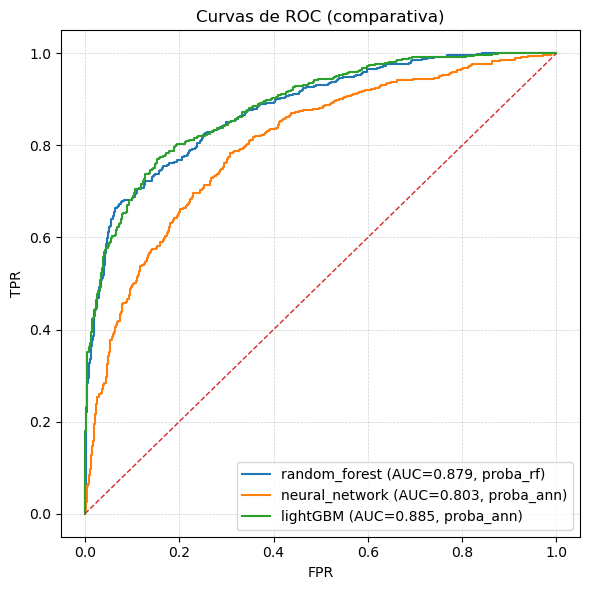

Figura ROC guardada en: experiments/figs_cmp_lightgbm_v5\roc_curves.png


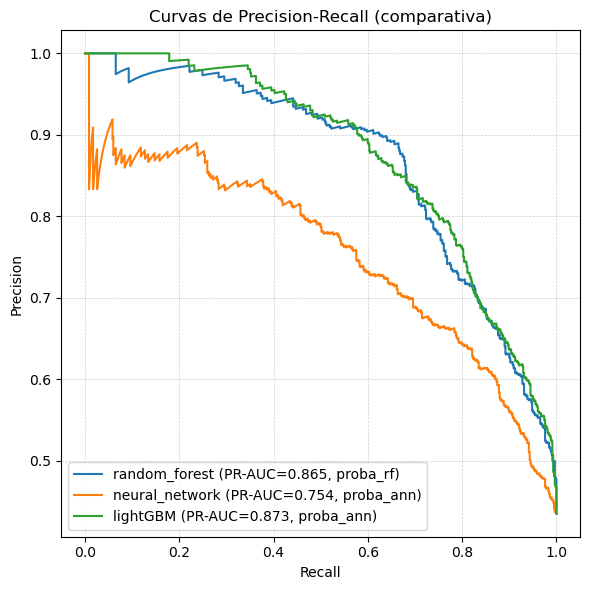

Figura PR-AUC guardada en: experiments/figs_cmp_lightgbm_v5\pr_curves.png


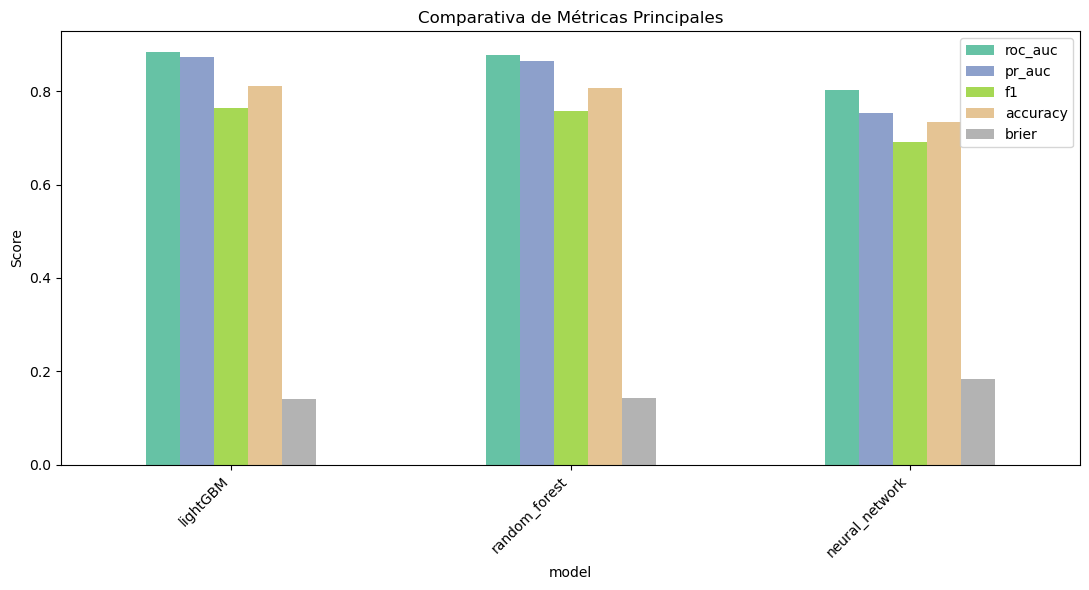

Figura de barras guardada en: experiments/figs_cmp_lightgbm_v5\bar_metrics_comparison.png


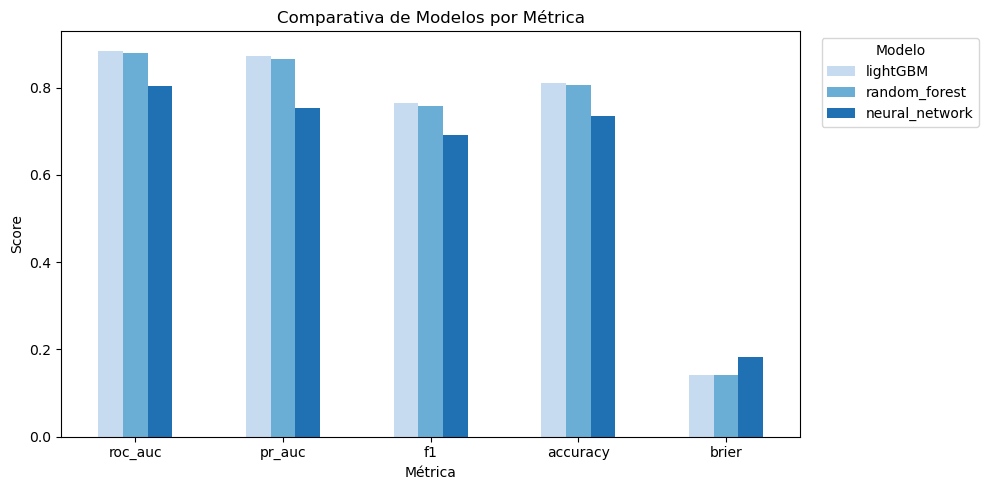

Figura transpuesta guardada en: experiments/figs_cmp_lightgbm_v5\bar_metrics_comparison_transposed.png


AttributeError: 'LGBMClassifier' object has no attribute 'coefs_'

In [23]:
# ===========================================
# ROC comparativa (cargando test_predictions.csv)
# ===========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


# EDITÁ: etiquetas -> carpeta del experimento (donde está test_predictions.csv)
exp_paths = {
    #"logreg_ridge": "./experiments/linear_baselines_v1",
    #"logistic_reg": "./experiments/logistic_reg_v1",
    #"ridge_reg": "./experiments/ridge_reg_v1",
    "random_forest": "./experiments/random_forest_v1",
    "neural_network": "./experiments/ann_v1",
    #"xgboost": "./experiments/xgboost_v1",
    "lightGBM": "./experiments/lightGBM_v1",
    #"catboost": "./experiments/catboost_v1",
    #"stackingOOF": "./experiments/stacking_v1",
    #"stackingPlus": "./experiments/stacking_plus_v1"
}

# Si querés filtrar calibrados o no, podés armar dos listas y graficar por separado.

def load_pred(csv_path):
    dfp = pd.read_csv(csv_path)
    # Heurística para encontrar columna de probas
    proba_cols = [c for c in dfp.columns if c.lower() in ("y_proba","proba_cal","proba_rf","proba_rf_cal","proba_raw")]
    if not proba_cols:
        # fallback: primera col que empiece con 'proba'
        proba_cols = [c for c in dfp.columns if c.lower().startswith("proba")]
    if "y_true" not in dfp.columns or not proba_cols:
        raise ValueError(f"Columnas esperadas no encontradas en {csv_path} (necesito y_true y alguna proba_*)")
    # preferí calibrada si existe
    preferred = None
    for cand in ["proba_cal","y_proba"]:
        if cand in dfp.columns:
            preferred = cand
            break
    if preferred is None:
        preferred = proba_cols[0]
    y_true = dfp["y_true"].astype(int).values
    y_proba = dfp[preferred].astype(float).values
    return y_true, y_proba, preferred

STAMP = time.strftime("%Y%m%d_%H%M%S")
FIG_DIR = f"experiments/figs_cmp_lightgbm_v5"
os.makedirs(FIG_DIR, exist_ok=True)

# plt.figure(figsize=(8.5, 6))
# handles = []
# labels  = []

# for label, exp_dir in exp_paths.items():
#     csv_path = os.path.join(exp_dir, "test_predictions.csv")
#     if not os.path.exists(csv_path):
#         print(f"[WARN] No existe: {csv_path} — lo salto.")
#         continue
#     y_true, y_proba, which = load_pred(csv_path)
#     fpr, tpr, _ = roc_curve(y_true, y_proba)
#     auc = roc_auc_score(y_true, y_proba)
#     h, = plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")
#     handles.append(h); labels.append(label)


# ---------------------------
# ROC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] No existe: {csv_path} — lo salto.")
        continue
    y_true, y_proba, which = load_pred(csv_path)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas de ROC (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
roc_path = os.path.join(FIG_DIR, "roc_curves.png")
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura ROC guardada en:", roc_path)


# ---------------------------
# PR-AUC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        continue
    y_true, y_proba, which = load_pred(csv_path)
    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, prec, label=f"{label} (PR-AUC={ap:.3f}, {which})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas de Precision-Recall (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
pr_path = os.path.join(FIG_DIR, "pr_curves.png")
plt.savefig(pr_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura PR-AUC guardada en:", pr_path)


# ----------------------------------------
# Barras comparando métricas principales
# ----------------------------------------
import json
metrics = []
for label, exp_dir in exp_paths.items():
    metrics_path = os.path.join(exp_dir, "metrics.json")
    if not os.path.exists(metrics_path): continue
    with open(metrics_path) as f:
        mets = json.load(f)
        # detecta clave de modelo
        key = list(mets.keys())[0]
        val = mets[key]
        metrics.append({
            "model": label,
            "roc_auc": val["roc_auc"],
            "pr_auc": val["pr_auc"],
            "f1": val["f1"],
            "accuracy": val["accuracy"],
            "brier": val["brier"]
        })
dfm = pd.DataFrame(metrics).set_index("model").sort_values("pr_auc", ascending=False)

ax = dfm.plot(kind="bar", figsize=(11, 6), colormap="Set2")
plt.title("Comparativa de Métricas Principales")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
bar_path = os.path.join(FIG_DIR, "bar_metrics_comparison.png")
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura de barras guardada en:", bar_path)

# ----------------------------------------
# Barras transpuestas: métricas en eje X, modelos en colores verdes
# ----------------------------------------
import seaborn as sns

# Transponemos para que métricas sean columnas
dfm_t = dfm.transpose()

# Paleta verde personalizada (usamos tonos diferentes si hay muchos modelos)
green_palette = sns.color_palette("Blues", n_colors=len(dfm_t.columns))

ax = dfm_t.plot(kind="bar", figsize=(10, 5), color=green_palette)
plt.title("Comparativa de Modelos por Métrica")
plt.ylabel("Score")
plt.xlabel("Métrica")
plt.xticks(rotation=0)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
bar_transposed_path = os.path.join(FIG_DIR, "bar_metrics_comparison_transposed.png")
plt.savefig(bar_transposed_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura transpuesta guardada en:", bar_transposed_path)

# ----------------------------------------
# Top 15 más importantes
# ----------------------------------------
# Cargar el modelo entrenado
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargá el modelo con el preprocesamiento y ANN
model = joblib.load("experiments/lightgbm_v1/best_lgb.pkl")  # corregí el nombre si es otro

# Extraer nombres de variables del preprocesador
feature_names = model.named_steps["pre"].get_feature_names_out()

# Extraer coeficientes de la primera capa oculta (aprox. de importancia)
# .coefs_ es una lista de arrays: una por cada capa, entre capas. Tomamos la primera.
coefs_input_hidden = model.named_steps["clf"].coefs_[0]  # shape: (n_features, n_hidden)

# Calculamos la importancia como la suma del valor absoluto por neurona de entrada
importances = np.abs(coefs_input_hidden).sum(axis=1)

# Tomamos las 15 más importantes
indices = np.argsort(importances)[-15:][::-1]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[indices], align='center')
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa (aprox.)")
plt.title("Top 15 variables más influyentes (XGBoost)")
plt.grid(True)
plt.tight_layout()

top_features_path = os.path.join(FIG_DIR, "top_features_ann.png")
plt.savefig(top_features_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura guardada en:", top_features_path)



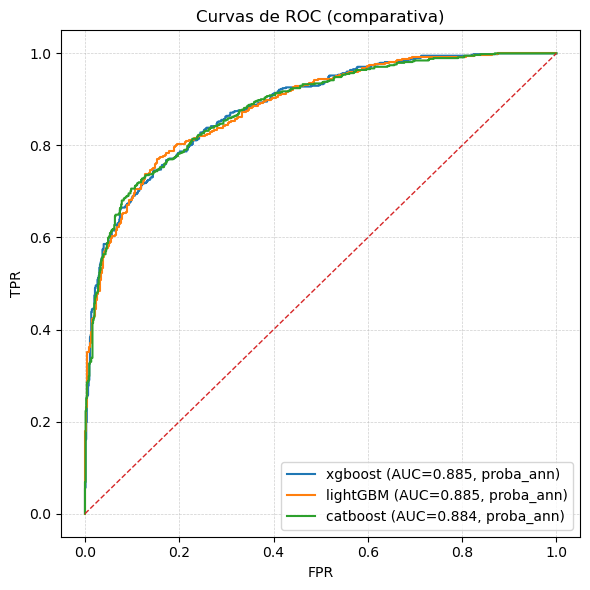

Figura ROC guardada en: experiments/figs_cmp_boostings_v6\roc_curves.png


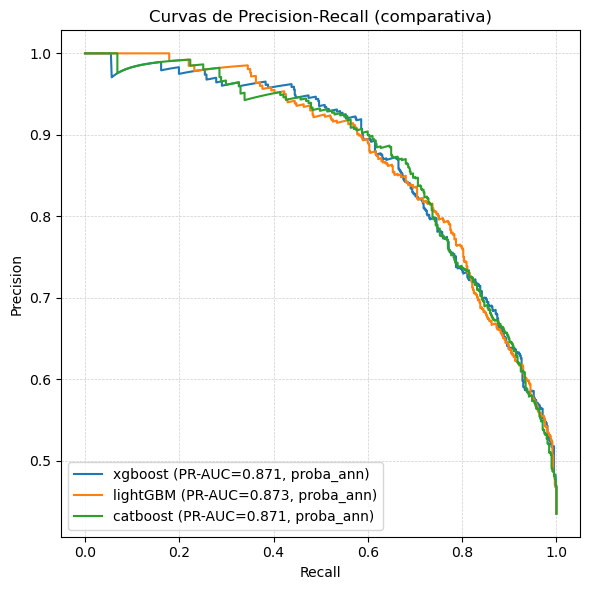

Figura PR-AUC guardada en: experiments/figs_cmp_boostings_v6\pr_curves.png


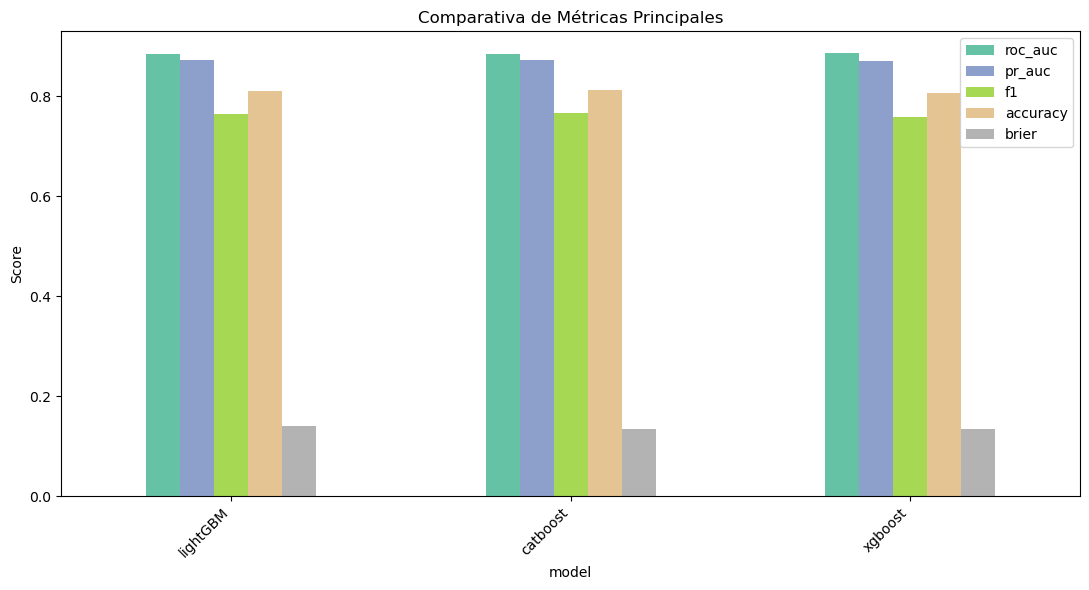

Figura de barras guardada en: experiments/figs_cmp_boostings_v6\bar_metrics_comparison.png


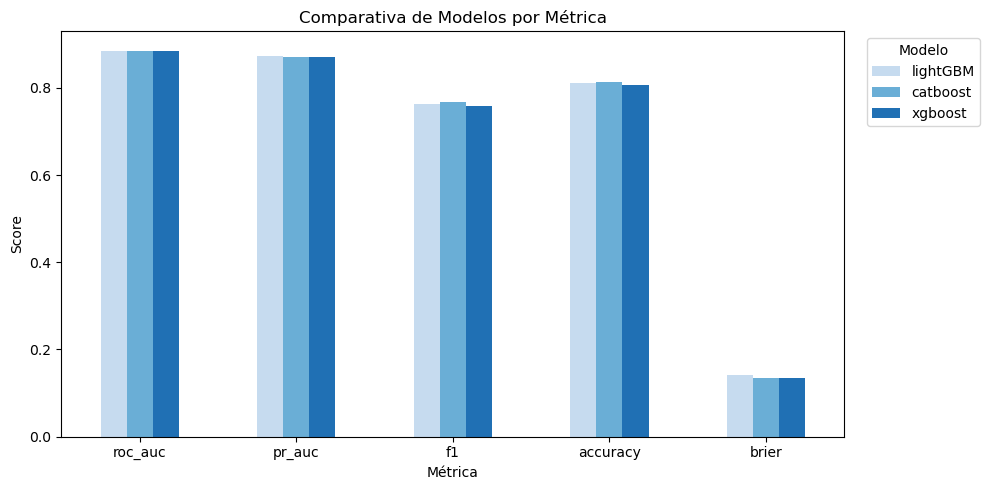

Figura transpuesta guardada en: experiments/figs_cmp_boostings_v6\bar_metrics_comparison_transposed.png


AttributeError: 'LGBMClassifier' object has no attribute 'coefs_'

In [24]:
# ===========================================
# ROC comparativa (cargando test_predictions.csv)
# ===========================================
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score


# EDITÁ: etiquetas -> carpeta del experimento (donde está test_predictions.csv)
exp_paths = {
    #"logreg_ridge": "./experiments/linear_baselines_v1",
    #"logistic_reg": "./experiments/logistic_reg_v1",
    #"ridge_reg": "./experiments/ridge_reg_v1",
    #"random_forest": "./experiments/random_forest_v1",
    #"neural_network": "./experiments/ann_v1",
    "xgboost": "./experiments/xgboost_v1",
    "lightGBM": "./experiments/lightGBM_v1",
    "catboost": "./experiments/catboost_v1",
    #"stackingOOF": "./experiments/stacking_v1",
    #"stackingPlus": "./experiments/stacking_plus_v1"
}

# Si querés filtrar calibrados o no, podés armar dos listas y graficar por separado.

def load_pred(csv_path):
    dfp = pd.read_csv(csv_path)
    # Heurística para encontrar columna de probas
    proba_cols = [c for c in dfp.columns if c.lower() in ("y_proba","proba_cal","proba_rf","proba_rf_cal","proba_raw")]
    if not proba_cols:
        # fallback: primera col que empiece con 'proba'
        proba_cols = [c for c in dfp.columns if c.lower().startswith("proba")]
    if "y_true" not in dfp.columns or not proba_cols:
        raise ValueError(f"Columnas esperadas no encontradas en {csv_path} (necesito y_true y alguna proba_*)")
    # preferí calibrada si existe
    preferred = None
    for cand in ["proba_cal","y_proba"]:
        if cand in dfp.columns:
            preferred = cand
            break
    if preferred is None:
        preferred = proba_cols[0]
    y_true = dfp["y_true"].astype(int).values
    y_proba = dfp[preferred].astype(float).values
    return y_true, y_proba, preferred

STAMP = time.strftime("%Y%m%d_%H%M%S")
FIG_DIR = f"experiments/figs_cmp_boostings_v6"
os.makedirs(FIG_DIR, exist_ok=True)

# plt.figure(figsize=(8.5, 6))
# handles = []
# labels  = []

# for label, exp_dir in exp_paths.items():
#     csv_path = os.path.join(exp_dir, "test_predictions.csv")
#     if not os.path.exists(csv_path):
#         print(f"[WARN] No existe: {csv_path} — lo salto.")
#         continue
#     y_true, y_proba, which = load_pred(csv_path)
#     fpr, tpr, _ = roc_curve(y_true, y_proba)
#     auc = roc_auc_score(y_true, y_proba)
#     h, = plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")
#     handles.append(h); labels.append(label)


# ---------------------------
# ROC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] No existe: {csv_path} — lo salto.")
        continue
    y_true, y_proba, which = load_pred(csv_path)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f}, {which})")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas de ROC (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
roc_path = os.path.join(FIG_DIR, "roc_curves.png")
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura ROC guardada en:", roc_path)


# ---------------------------
# PR-AUC Curves
# ---------------------------
plt.figure(figsize=(6, 6))
for label, exp_dir in exp_paths.items():
    csv_path = os.path.join(exp_dir, "test_predictions.csv")
    if not os.path.exists(csv_path):
        continue
    y_true, y_proba, which = load_pred(csv_path)
    prec, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.plot(recall, prec, label=f"{label} (PR-AUC={ap:.3f}, {which})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas de Precision-Recall (comparativa)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
pr_path = os.path.join(FIG_DIR, "pr_curves.png")
plt.savefig(pr_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura PR-AUC guardada en:", pr_path)


# ----------------------------------------
# Barras comparando métricas principales
# ----------------------------------------
import json
metrics = []
for label, exp_dir in exp_paths.items():
    metrics_path = os.path.join(exp_dir, "metrics.json")
    if not os.path.exists(metrics_path): continue
    with open(metrics_path) as f:
        mets = json.load(f)
        # detecta clave de modelo
        key = list(mets.keys())[0]
        val = mets[key]
        metrics.append({
            "model": label,
            "roc_auc": val["roc_auc"],
            "pr_auc": val["pr_auc"],
            "f1": val["f1"],
            "accuracy": val["accuracy"],
            "brier": val["brier"]
        })
dfm = pd.DataFrame(metrics).set_index("model").sort_values("pr_auc", ascending=False)

ax = dfm.plot(kind="bar", figsize=(11, 6), colormap="Set2")
plt.title("Comparativa de Métricas Principales")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
bar_path = os.path.join(FIG_DIR, "bar_metrics_comparison.png")
plt.savefig(bar_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura de barras guardada en:", bar_path)

# ----------------------------------------
# Barras transpuestas: métricas en eje X, modelos en colores verdes
# ----------------------------------------
import seaborn as sns

# Transponemos para que métricas sean columnas
dfm_t = dfm.transpose()

# Paleta verde personalizada (usamos tonos diferentes si hay muchos modelos)
green_palette = sns.color_palette("Blues", n_colors=len(dfm_t.columns))

ax = dfm_t.plot(kind="bar", figsize=(10, 5), color=green_palette)
plt.title("Comparativa de Modelos por Métrica")
plt.ylabel("Score")
plt.xlabel("Métrica")
plt.xticks(rotation=0)
plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
bar_transposed_path = os.path.join(FIG_DIR, "bar_metrics_comparison_transposed.png")
plt.savefig(bar_transposed_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura transpuesta guardada en:", bar_transposed_path)

# ----------------------------------------
# Top 15 más importantes
# ----------------------------------------
# Cargar el modelo entrenado
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os

# Cargá el modelo con el preprocesamiento y ANN
model = joblib.load("experiments/lightgbm_v1/best_lgb.pkl")  # corregí el nombre si es otro

# Extraer nombres de variables del preprocesador
feature_names = model.named_steps["pre"].get_feature_names_out()

# Extraer coeficientes de la primera capa oculta (aprox. de importancia)
# .coefs_ es una lista de arrays: una por cada capa, entre capas. Tomamos la primera.
coefs_input_hidden = model.named_steps["clf"].coefs_[0]  # shape: (n_features, n_hidden)

# Calculamos la importancia como la suma del valor absoluto por neurona de entrada
importances = np.abs(coefs_input_hidden).sum(axis=1)

# Tomamos las 15 más importantes
indices = np.argsort(importances)[-15:][::-1]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[indices], align='center')
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importancia relativa (aprox.)")
plt.title("Top 15 variables más influyentes (XGBoost)")
plt.grid(True)
plt.tight_layout()

top_features_path = os.path.join(FIG_DIR, "top_features_ann.png")
plt.savefig(top_features_path, dpi=200, bbox_inches="tight")
plt.show()
print("Figura guardada en:", top_features_path)



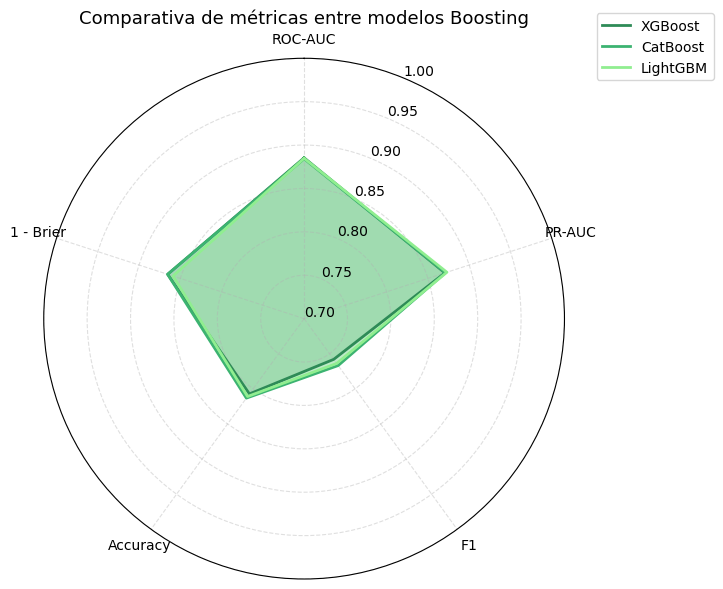

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Radar chart comparativo de métricas
# =============================

# Métricas: cuanto más alto mejor, excepto Brier (por eso lo invertimos)
labels = ["ROC-AUC", "PR-AUC", "F1", "Accuracy", "1 - Brier"]

# Valores de las métricas
xgb =    [0.8853, 0.8706, 0.7580, 0.8072, 1 - 0.1347]
cat =    [0.8842, 0.8712, 0.7668, 0.8132, 1 - 0.1346]
lgb =    [0.8847, 0.8730, 0.7638, 0.8109, 1 - 0.1411]
lgoreg =    [0.784060, 0.724983, 0.702568, 0.731689, 1 - 0.188271]

# 5	lightGBM	lightgbm	0.884664	0.872983	0.763772	0.810912	0.141139
# 6	catboost	catboost	0.884244	0.871188	0.766791	0.813154	0.134613
# 4	xgboost	xgboost	0.885255	0.870647	0.757974	0.807175	0.134708
# 2	random_forest	rf	0.878891	0.864661	0.757717	0.806428	0.142542
# 3	neural_network	ann_mlp	0.803051	0.753547	0.691638	0.735426	0.183765
# 1	ridge_reg	ridge	0.785646	0.726925	0.702658	0.732436	0.206058
# 0	logistic_reg	logreg	0.784060	0.724983	0.702568	0.731689	0.188271


model_names = ["XGBoost", "CatBoost", "LightGBM", "logistic_reg"]
colors = ["#2e8b57", "#3cb371", "#90ee90", "red"]  # tonos de verde

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # cerrar el gráfico

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for values, label, color in zip([xgb, cat, lgb], model_names, colors):
    values += values[:1]  # cerrar la figura
    ax.plot(angles, values, label=label, color=color, linewidth=2)
    ax.fill(angles, values, alpha=0.25, color=color)

# Ejes y etiquetas
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0.7, 1.0)  # ajustar escala si querés más detalle

# Decoración
ax.set_title("Comparativa de métricas entre modelos Boosting", fontsize=13)
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


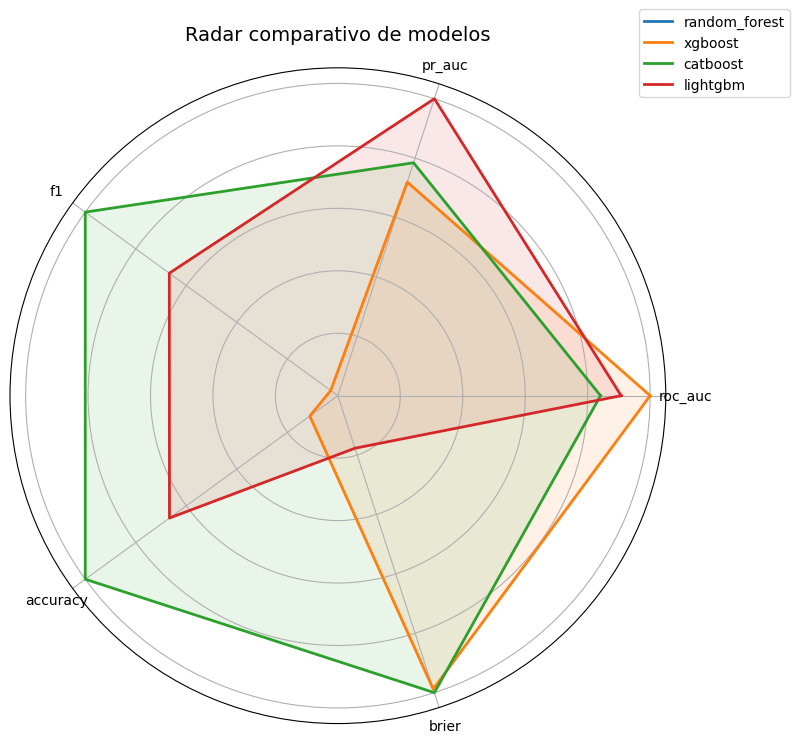

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Datos
models = ['base','log_reg', 'ridge_reg', 'ann_mlp', 'random_forest', 'xgboost', 'catboost', 'lightgbm']
models = ['random_forest', 'xgboost', 'catboost', 'lightgbm']
metrics = ['roc_auc', 'pr_auc', 'f1', 'accuracy', 'brier']

# Tabla de métricas por modelo
data = {
    # 'base':     [0.75, 0.69, 0.67, 0.70, 0.21],
    # 'log_reg':     [0.784060, 0.724983, 0.702568, 0.731689, 0.188271],
    # 'ridge_reg':      [0.785646, 0.726925, 0.702658, 0.732436, 0.206058],
    # 'ann_mlp':    [0.803051, 0.753547, 0.691638, 0.735426, 0.183765],
    'random_forest':         [0.878891, 0.864661, 0.757717, 0.806428, 0.142542],
    'xgboost':    [0.885255, 0.870647, 0.757974, 0.807175, 0.134708],
    'catboost':   [0.884244, 0.871188, 0.766791, 0.813154, 0.134613],
    'lightgbm':   [0.884664, 0.872983, 0.763772, 0.810912, 0.141139],
}

# Convertir a matriz y escalar (invirtiendo Brier)
mat = np.array([data[model] for model in models])
mat[:, -1] = 1 - mat[:, -1]  # Invertir Brier Score

# Normalizar entre 0 y 1 para el radar
scaler = MinMaxScaler()
mat_norm = scaler.fit_transform(mat)

# Preparar el radar
labels = metrics
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # cerrar círculo

# Setup gráfico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = plt.cm.tab10.colors  # hasta 10 colores bien distintos

# Dibujar líneas por modelo
for idx, model in enumerate(models):
    values = mat_norm[idx].tolist()
    values += values[:1]  # cerrar
    ax.plot(angles, values, label=model, color=colors[idx % len(colors)], linewidth=2)
    ax.fill(angles, values, alpha=0.1, color=colors[idx % len(colors)])

# Estética
ax.set_title("Radar comparativo de modelos", fontsize=14, pad=20)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticklabels([])
ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


In [18]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, roc_auc_score
import matplotlib.pyplot as plt
import joblib
import numpy as np
import os

# === Configurable ===
model_path = "./experiments/random_forest_v1/best_rf.pkl"  # Cambiá esto según el modelo
model_name = "Random Forest"
X_sample = X_train.copy()  # Usá los datos con los que entrenaste
y_sample = y_train.copy()

# === Load modelo y evaluar ===
model = joblib.load(model_path)

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_sample,
    y_sample,
    scoring=make_scorer(roc_auc_score),
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# === Plot ===
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Entrenamiento", color="green")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validación", color="limegreen")
plt.title(f"Curva de aprendizaje - {model_name}")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("ROC-AUC")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()

out_path = f"./experiments/figs_cmp_learning_curve_{model_name.replace(' ','_')}.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Curva guardada en:", out_path)


NameError: name 'X_train' is not defined

In [59]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

def graficar_top_15_features(model, nombre):
    # Obtener nombres de variables transformadas
    feature_names = model.named_steps["pre"].get_feature_names_out()
    
    # Extraer importancias del modelo de boosting
    clf = model.named_steps["clf"]
    
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_
    else:
        raise AttributeError("Este modelo no tiene 'feature_importances_' disponible.")
    
    # Obtener top 15
    top_n = 15
    indices = np.argsort(importances)[-top_n:][::-1]
    print(nombre +" -> ")
    print([feature_names[i] +": "+ str(importances[i]) for i in indices])
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align="center", color="#2a9d8f")
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.xlabel("Importancia")
    plt.title(f"Top 15 variables más importantes para {nombre}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    return feature_names[indices]

XGBoost -> 
['bin__has_whitepaper: 0.22309513', 'bin__is_tax_regulated: 0.031128028', 'bin__has_twitter: 0.029063467', 'num__start_year: 0.026802199', 'num__total_tokens: 0.0239943', 'num__ticket_minmax_ratio: 0.02331891', 'num__soft_cap: 0.022820858', 'num__max_purchase: 0.021834824', 'num__ico_score: 0.02007689', 'cat__category_Social Network: 0.018390724', 'num__cap_ratio_soft_over_hard: 0.016620241', 'bin__has_github: 0.015297712', 'cat__platform_Waves: 0.015085549', 'bin__has_website: 0.0146943955', 'cat__category_Gaming: 0.01427142']


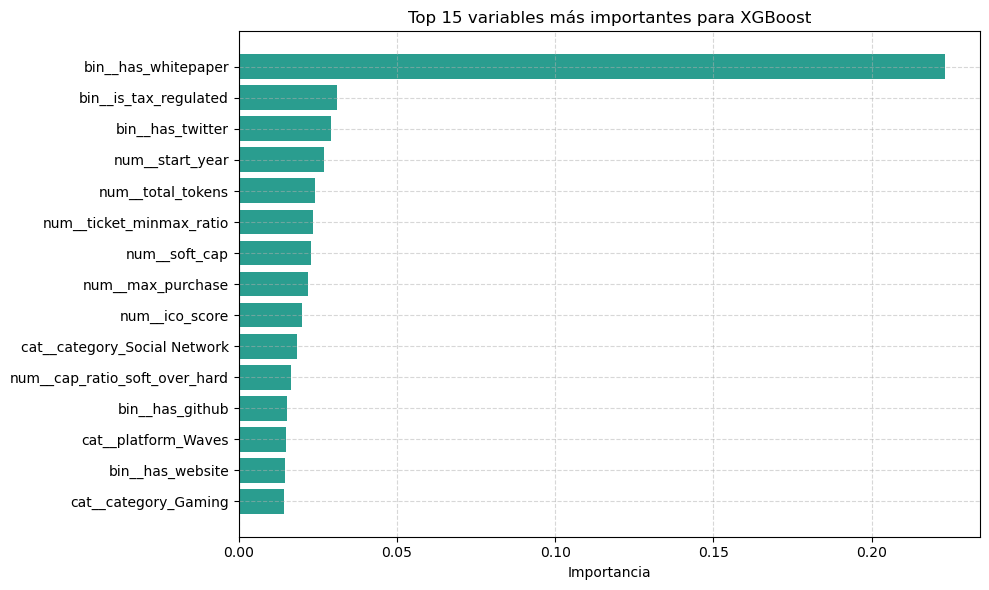

['bin__has_whitepaper' 'bin__is_tax_regulated' 'bin__has_twitter'
 'num__start_year' 'num__total_tokens' 'num__ticket_minmax_ratio'
 'num__soft_cap' 'num__max_purchase' 'num__ico_score'
 'cat__category_Social Network' 'num__cap_ratio_soft_over_hard'
 'bin__has_github' 'cat__platform_Waves' 'bin__has_website'
 'cat__category_Gaming']
CatBoost -> 
['num__soft_cap: 11.581600502724744', 'num__cap_ratio_soft_over_hard: 10.460027564814087', 'num__ico_score: 8.896945048149746', 'num__total_tokens: 6.470387624413806', 'num__hard_cap: 5.886649885615816', 'num__max_purchase: 5.218552027253998', 'num__tokens_for_sale: 5.204106853362438', 'num__token_price: 5.1632056612017845', 'num__ticket_minmax_ratio: 4.900119078807644', 'num__start_year: 4.299402423559103', 'num__min_purchase: 3.197677710681723', 'num__start_qtr: 3.073291912810439', 'bin__is_tax_regulated: 2.5624159003533697', 'bin__has_website: 2.14404249515186', 'bin__accepts_BTC: 2.0421474441189336']


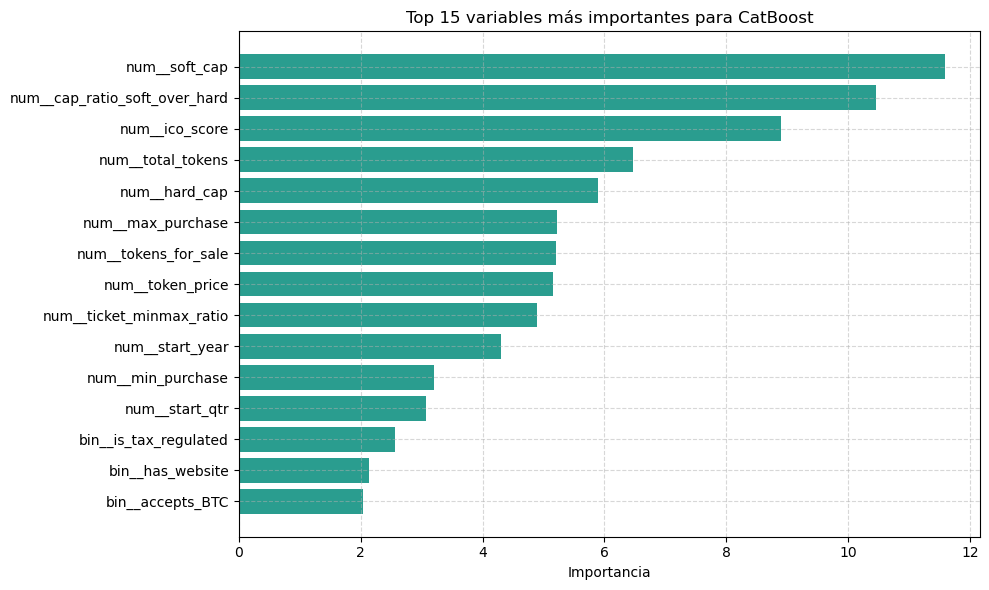

['num__soft_cap' 'num__cap_ratio_soft_over_hard' 'num__ico_score'
 'num__total_tokens' 'num__hard_cap' 'num__max_purchase'
 'num__tokens_for_sale' 'num__token_price' 'num__ticket_minmax_ratio'
 'num__start_year' 'num__min_purchase' 'num__start_qtr'
 'bin__is_tax_regulated' 'bin__has_website' 'bin__accepts_BTC']
LightGBM -> 
['num__soft_cap: 4649', 'num__hard_cap: 4466', 'num__token_price: 4290', 'num__tokens_for_sale: 4174', 'num__sale_vs_capacity_ratio: 4141', 'num__cap_ratio_soft_over_hard: 4120', 'num__price_to_softcap_ratio: 4031', 'num__ico_score: 2991', 'num__total_tokens: 1512', 'num__start_qtr: 1480', 'num__min_purchase: 1417', 'num__ticket_minmax_ratio: 1256', 'num__max_purchase: 1199', 'bin__has_contract_address: 986', 'cat__location_Other: 772']


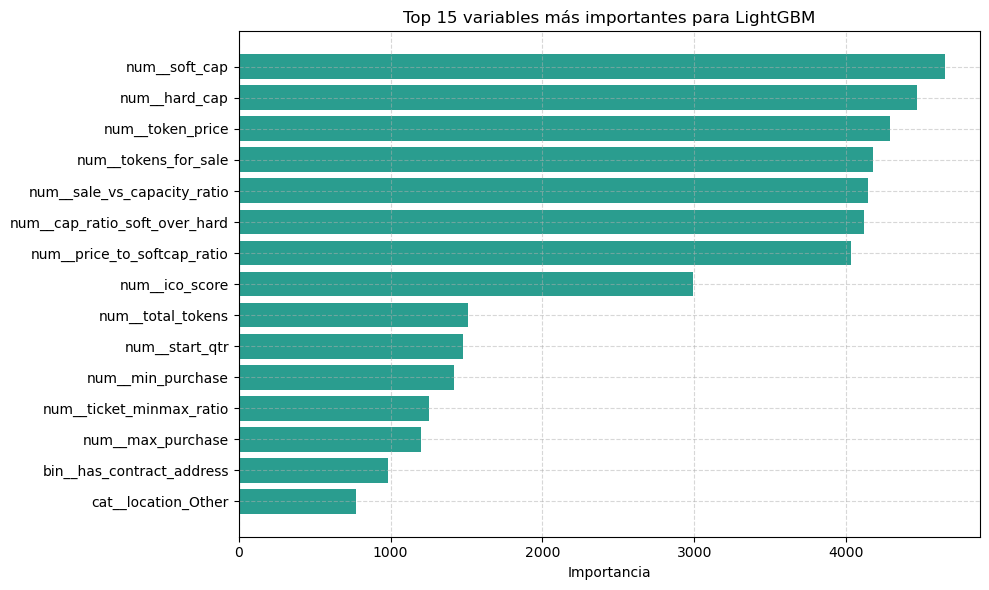

['num__soft_cap' 'num__hard_cap' 'num__token_price' 'num__tokens_for_sale'
 'num__sale_vs_capacity_ratio' 'num__cap_ratio_soft_over_hard'
 'num__price_to_softcap_ratio' 'num__ico_score' 'num__total_tokens'
 'num__start_qtr' 'num__min_purchase' 'num__ticket_minmax_ratio'
 'num__max_purchase' 'bin__has_contract_address' 'cat__location_Other']


In [60]:

# Ruta al modelo (ajustá según el que quieras analizar)
model_path = "experiments/xgboost_v1/best_xgb.pkl" 
model = joblib.load(model_path)
print(graficar_top_15_features(model, "XGBoost"))
model_path = "experiments/catboost_v1/best_cat.pkl"  
model = joblib.load(model_path)
print(graficar_top_15_features(model, "CatBoost"))
model_path = "experiments/lightgbm_v1/best_lgb.pkl" 
model = joblib.load(model_path)
print(graficar_top_15_features(model, "LightGBM"))



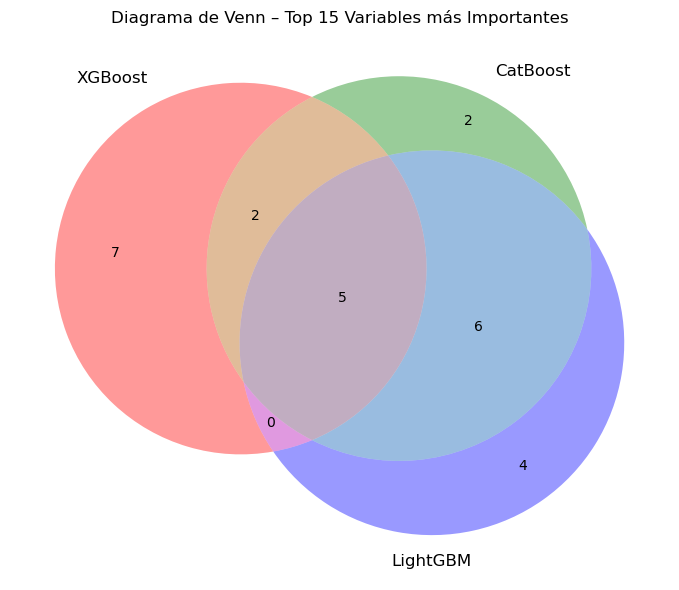

{'num__max_purchase', 'num__ico_score', 'num__soft_cap', 'num__cap_ratio_soft_over_hard', 'num__ticket_minmax_ratio'}


In [67]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Top 10 features por modelo
xgb_top10 = {
    'bin__has_whitepaper', 'bin__is_tax_regulated', 'bin__has_twitter',
    'num__start_year' 'num__total_tokens', 'num__ticket_minmax_ratio',
    'num__soft_cap', 'num__max_purchase', 'num__ico_score',
    'cat__category_Social Network', 'num__cap_ratio_soft_over_hard',
    'bin__has_github', 'cat__platform_Waves', 'bin__has_website',
    'cat__category_Gaming'
}

cat_top10 = {
    'num__soft_cap', 'num__cap_ratio_soft_over_hard', 'num__ico_score',
    'num__total_tokens', 'num__hard_cap', 'num__max_purchase',
    'num__tokens_for_sale', 'num__token_price', 'num__ticket_minmax_ratio',
    'num__start_year', 'num__min_purchase', 'num__start_qtr',
    'bin__is_tax_regulated', 'bin__has_website', 'bin__accepts_BTC'
}

lgb_top10 = {
    'num__soft_cap', 'num__hard_cap', 'num__token_price', 'num__tokens_for_sale',
    'num__sale_vs_capacity_ratio', 'num__cap_ratio_soft_over_hard',
    'num__price_to_softcap_ratio', 'num__ico_score', 'num__total_tokens',
    'num__start_qtr', 'num__min_purchase', 'num__ticket_minmax_ratio',
    'num__max_purchase', 'bin__has_contract_address', 'cat__location_Other'
}

plt.figure(figsize=(8, 6))
venn = venn3(
    [xgb_top10, cat_top10, lgb_top10],
    set_labels=("XGBoost", "CatBoost", "LightGBM")
)
plt.title("Diagrama de Venn – Top 15 Variables más Importantes")
plt.tight_layout()
plt.show()

xgb_cat = xgb_top10 & cat_top10
xgb_lgb = xgb_top10 & lgb_top10
lgb_cat = lgb_top10 & cat_top10
xgb_cat_lgb = xgb_top10 & cat_top10 & lgb_top10

print(xgb_cat_lgb)


In [55]:
%pip install matplotlib_venn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib_venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=103b5d007d22203f7d254126af5d50760bda81922fc7605976c40ac1586a2e02
  Stored in directory: c:\users\dmigl\appdata\local\pip\cache\wheels\c2\47\0c\f014c55a1cfd56dce41a1cafd23e3c590652b5e71330cc181c
Successfully built matplotlib_venn
Note: you may need to restart the kernel to use updated packages.
